In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pathlib import Path
from PIL import Image
import torchvision.utils as vutils
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
from tqdm.notebook import tqdm
import math
from sklearn.metrics import accuracy_score
from skimage import io

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
#from fastai code
def top_k_accuracy(input, targs, k=3):
    "Computes the Top-k accuracy (target is in the top k predictions)."
    input = input.topk(k=k, dim=-1)[1]
    targs = targs.unsqueeze(dim=-1).expand_as(input)
    return (input == targs).max(dim=-1)[0].float().mean()

In [5]:
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L359
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

In [6]:
image_size = 224
std,mean = [0.229, 0.224, 0.225],[0.485, 0.456, 0.406] # pretrained models used these values


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
    ])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

In [7]:
def my_imshow(img, title='', std=std, mean=mean):
    img = img.permute(1,2,0).cpu()
    img = img * torch.tensor(std) + torch.tensor(mean)
    img = np.clip(img, 0, 1)
    plt.figure (figsize = (16, 16))
    plt.imshow(img)
    plt.title(title)

In [8]:
class IFoodDataset(Dataset):
    def __init__(self, labels_csv, data_path, transforms):
        self.labels_df = pd.read_csv(labels_csv)
        self.data_path = root_path / data_path
        self.compose = transforms
    def __len__(self):
        return len(self.labels_df)
    
    def __getitem__(self, idx):
        img_name = self.data_path/self.labels_df.iloc[idx, 0]
        image = io.imread(img_name)
        image = Image.fromarray(image)
        image = self.compose(image)
        return {'image':image,'label':self.labels_df.iloc[idx, 1]}

In [9]:
bs=128
root_path = Path.cwd() / 'ifood' 
train_labels_csv = 'train_labels.csv'
train_data_path = 'train_set'
train_dataset = IFoodDataset(root_path/train_labels_csv, root_path/train_data_path, train_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True,num_workers=4)
val_labels_csv = 'val_labels.csv'
val_data_path = 'val_set'
val_dataset = IFoodDataset(root_path/val_labels_csv, root_path/val_data_path, test_transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=True,num_workers=4)

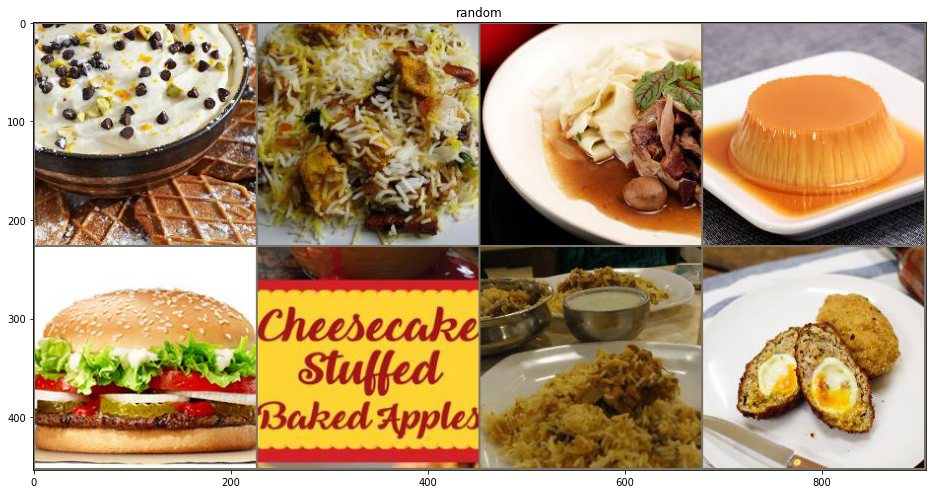

In [10]:
batch = next(iter(val_dataloader))
my_imshow(vutils.make_grid(batch['image'][:8], nrow=4, padding=2), 'random')

In [17]:
# fit/test functions
def fit(iterator, model, optimizer, criterion):
    model.train()
    losses = AverageMeter('Loss', ':.4e')
    accuracy = AverageMeter('Acc@1', ':6.2f')
    for batch in tqdm(iterator,leave=False):
        optimizer.zero_grad()
        y_hat = model(batch['image'].to(device))
        y = batch['label'].to(device)
        loss = criterion(y_hat, y)        
        loss.backward()
        optimizer.step()
        losses.update(loss.item(), batch['image'].shape[0])
        accuracy.update(top_k_accuracy(y_hat,y,3).item(), batch['image'].shape[0])
    return losses.avg ,accuracy.avg

def test(iterator, model, criterion):
    model.eval() 
    losses = AverageMeter('Loss', ':.4e')
    accuracy = AverageMeter('Acc@1', ':6.2f')
    for batch in tqdm(iterator,leave=True):                    
        with torch.no_grad():
            y_hat = model(batch['image'].to(device))
        y = batch['label'].to(device)
        loss = criterion(y_hat, y)
        losses.update(loss.item(), batch['image'].shape[0])
        accuracy.update(top_k_accuracy(y_hat,y,3).item(), batch['image'].shape[0])

    
    return losses.avg, accuracy.avg

In [18]:
def train_n_epochs(model, n, optimizer, train_dataloader, val_dataloader):
    criterion = nn.CrossEntropyLoss().to(device)
    for epoch in range(n):
        start_time = time.time()
        train_loss,train_acc = fit(train_dataloader, model, optimizer, criterion)
        valid_loss,valid_acc = test(val_dataloader, model, criterion)
        secs = int(time.time() - start_time)
        print(f'epoch {epoch}. time: {secs}[s]')
        print(f'\ttrain loss: {train_loss:.4f} accuracy: {train_acc:.4f}')
        print(f'\tvalidation loss: {valid_loss:.4f} accuracy: {valid_acc:.4f}')

In [19]:
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 251)
nn.init.kaiming_normal_(model.fc.weight)
nn.init.zeros_(model.fc.bias)
model = model.to(device)

In [20]:
#for param in model.layer4.parameters():
#    param.requires_grad = True

In [21]:
model = nn.DataParallel(model).to(device)

In [22]:
wd=1e-6
lr=1e-4
epochs=10
optimizer = optim.Adam(model.module.parameters(), lr=lr, weight_decay=wd)
train_n_epochs(model,epochs,optimizer, train_dataloader, val_dataloader)


epoch 0. time: 451[s]
	train loss: 3.5902 accuracy: 0.4163
	validation loss: 2.2020 accuracy: 0.6805



epoch 1. time: 450[s]
	train loss: 2.7313 accuracy: 0.5772
	validation loss: 1.8955 accuracy: 0.7303



epoch 2. time: 456[s]
	train loss: 2.4846 accuracy: 0.6229
	validation loss: 1.7393 accuracy: 0.7650



epoch 3. time: 456[s]
	train loss: 2.3366 accuracy: 0.6495
	validation loss: 1.6443 accuracy: 0.7826



epoch 4. time: 456[s]
	train loss: 2.2245 accuracy: 0.6693
	validation loss: 1.5478 accuracy: 0.7965



epoch 5. time: 453[s]
	train loss: 2.1274 accuracy: 0.6875
	validation loss: 1.5521 accuracy: 0.7961



epoch 6. time: 455[s]
	train loss: 2.0441 accuracy: 0.7021
	validation loss: 1.5270 accuracy: 0.7976



epoch 7. time: 454[s]
	train loss: 1.9841 accuracy: 0.7130
	validation loss: 1.4901 accuracy: 0.8071



epoch 8. time: 454[s]
	train loss: 1.9159 accuracy: 0.7238
	validation loss: 1.4880 accuracy: 0.8097



epoch 9. time: 455[s]
	train loss: 1.8670 accuracy: 0.7341
	validation loss: 1.4880 accuracy: 0.8105


In [23]:
torch.save(model.module.state_dict(), 'model.pt')

In [24]:
wd=1e-6
lr=1e-5
epochs=5
optimizer = optim.Adam(model.module.parameters(), lr=lr, weight_decay=wd)
train_n_epochs(model,epochs,optimizer, train_dataloader, val_dataloader)


epoch 0. time: 450[s]
	train loss: 1.6437 accuracy: 0.7720
	validation loss: 1.3173 accuracy: 0.8369



epoch 1. time: 451[s]
	train loss: 1.5746 accuracy: 0.7845
	validation loss: 1.3063 accuracy: 0.8390



epoch 2. time: 451[s]
	train loss: 1.5402 accuracy: 0.7894
	validation loss: 1.3079 accuracy: 0.8380



epoch 3. time: 450[s]
	train loss: 1.5162 accuracy: 0.7946
	validation loss: 1.3000 accuracy: 0.8408



epoch 4. time: 452[s]
	train loss: 1.4924 accuracy: 0.7975
	validation loss: 1.2912 accuracy: 0.8452


In [25]:
wd=1e-6
lr=5e-6
epochs=10
for param in model.parameters():
    param.requires_grad = True
optimizer = optim.Adam(model.module.parameters(), lr=lr, weight_decay=wd)
train_n_epochs(model,epochs,optimizer, train_dataloader, val_dataloader)


epoch 0. time: 452[s]
	train loss: 1.4674 accuracy: 0.8019
	validation loss: 1.2889 accuracy: 0.8432



epoch 1. time: 452[s]
	train loss: 1.4513 accuracy: 0.8050
	validation loss: 1.2876 accuracy: 0.8449



epoch 2. time: 445[s]
	train loss: 1.4474 accuracy: 0.8053
	validation loss: 1.2835 accuracy: 0.8446



epoch 3. time: 440[s]
	train loss: 1.4395 accuracy: 0.8070
	validation loss: 1.2906 accuracy: 0.8408



epoch 4. time: 438[s]
	train loss: 1.4334 accuracy: 0.8073
	validation loss: 1.2834 accuracy: 0.8459



epoch 5. time: 440[s]
	train loss: 1.4187 accuracy: 0.8099
	validation loss: 1.2858 accuracy: 0.8444



epoch 6. time: 444[s]
	train loss: 1.4183 accuracy: 0.8104
	validation loss: 1.2854 accuracy: 0.8410



epoch 7. time: 450[s]
	train loss: 1.4031 accuracy: 0.8131
	validation loss: 1.2885 accuracy: 0.8439



epoch 8. time: 438[s]
	train loss: 1.4004 accuracy: 0.8132
	validation loss: 1.2890 accuracy: 0.8413



epoch 9. time: 442[s]
	train loss: 1.3921 accuracy: 0.8149
	validation loss: 1.2937 accuracy: 0.8413


In [26]:
torch.save(model.module.state_dict(), 'model.pt')

## create kaggle submission

In [27]:
# Custom dataset with file name https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [28]:
test_dataset = ImageFolderWithPaths((root_path/'test_set/').as_posix(),test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False,num_workers=4)

In [29]:
model = models.resnet34(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 251)
model = model.to(device)
model = nn.DataParallel(model).to(device)

model.module.load_state_dict(torch.load('model.pt'))
model.eval();

In [16]:
results = torch.tensor([]).long()
paths=()
model.eval()
for batch in tqdm(test_dataloader,leave=False):                    
    with torch.no_grad():
        y_hat = model(batch[0].to(device)).topk(3).indices.cpu()
    paths=paths+batch[2]
    results=torch.cat([results,y_hat],dim=0)  

In [17]:
result_df = pd.DataFrame(results.tolist())
result_df['path']=pd.DataFrame(paths)
result_df['img_name']=result_df['path'].apply(lambda x: x.split('/')[-1])
result_df['label']=result_df.apply(lambda row:f'{row[0]} {row[1]} {row[2]}',axis=1)
result_df[['img_name','label']].to_csv('submission.csv',index=False)
result_df

,0,1,2,path,img_name,label
0,58,7,98,/home/yonatang/deepfood/notebooks/ifood/test_s...,test_000000.jpg,58 7 98
1,25,16,71,/home/yonatang/deepfood/notebooks/ifood/test_s...,test_000001.jpg,25 16 71
2,88,133,156,/home/yonatang/deepfood/notebooks/ifood/test_s...,test_000002.jpg,88 133 156
3,117,104,37,/home/yonatang/deepfood/notebooks/ifood/test_s...,test_000003.jpg,117 104 37
4,51,232,106,/home/yonatang/deepfood/notebooks/ifood/test_s...,test_000004.jpg,51 232 106
...,...,...,...,...,...,...
28372,1,220,156,/home/yonatang/deepfood/notebooks/ifood/test_s...,test_028394.jpg,1 220 156
28373,232,117,175,/home/yonatang/deepfood/notebooks/ifood/test_s...,test_028395.jpg,232 117 175
28374,107,234,209,/home/yonatang/deepfood/notebooks/ifood/test_s...,test_028396.jpg,107 234 209
28375,244,202,160,/home/yonatang/deepfood/notebooks/ifood/test_s...,test_028397.jpg,244 202 160


In [18]:
!kaggle competitions submit -c ifood-2019-fgvc6 -f submission.csv -m "validation submission"

100%|█████████████████████████████████████████| 740k/740k [00:02<00:00, 284kB/s]
Successfully submitted to iFood - 2019 at FGVC6